<a href="https://colab.research.google.com/github/hariseldon99/msph402b/blob/main/ODE_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Examples of ODEs (Boundary Value Problem)
===============================================

### Suggestion

Run the code cell below before the others to make sure that scipy is up to date and the figures render well.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 20
#!pip3 install --upgrade scipy

### Problem: Shooting Method for Solving Boundary Value Problems

Consider the following ODE:

\begin{equation*}
\frac{d^2y}{dt^2} = \frac{3}{2}y^2,
\end{equation*}
subject to the boundary conditions $y(0)=4,\;y(1)=1$. Use the shooting method in order to obtain a solution $y(t)$ that meets this boundary condition.

We note that the first-order IVP can be set as
\begin{equation*}
\begin{matrix}
\frac{du_1}{dt} &=u_2\\
\frac{du_2}{dt} &= \frac{3}{2}u^2_1
\end{matrix},
\end{equation*}
with initial conditions $u_1 = 4,\;u_2=s$. We need to find the $s$ that yields $u_1(1) = 1$. In other words, we basically need to find the root of the function $F(s)=u_1(1;s)-1$. So now, $u_1$, or $y$ is characterized by time $t$, and a *parameter* $s$, where the right value of the parameter is obtained by finding the root of $F(s)$. Let us first simply plot IVP solutions for this system for sifferent values of $s$ and see which one yields $y(1;s) = u_1(1;s) = 1$.  The point $y(1)=1$ is marked in the plots below.

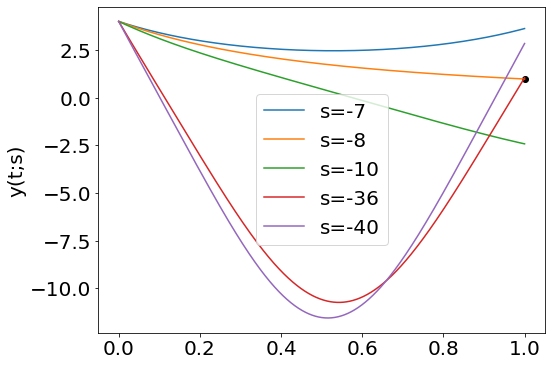

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

def rhs(t, u):
    u1, u2 = u
    du1dt = u2
    du2dt = (3/2)* u1**2
    return [du1dt, du2dt]

srange = [-7, -8, -10, -36, -40]
trange = np.linspace(0.0, 1.0, 1000) 

for s in srange:
    sol = solve_ivp(rhs,[0,1],[4,s], t_eval=trange)
    plt.plot(trange, sol.y[0,:], label=f's={s}')
    
plt.scatter(1,1, color='black')
plt.legend()
plt.ylabel('y(t;s)')
plt.show()

From this curve, we can see that there are two trajectories that satisfy the boundary conditions, corresponding to $s\approx-8$ and $s\approx-36$. We can refine these estimates by obtaining the root of the function $F(s)$ using a root finding method. Since we already have decent estimates, let's polish them using the Newton-Raphson method in the $scipy.optimize.newton$ routine from Scipy.

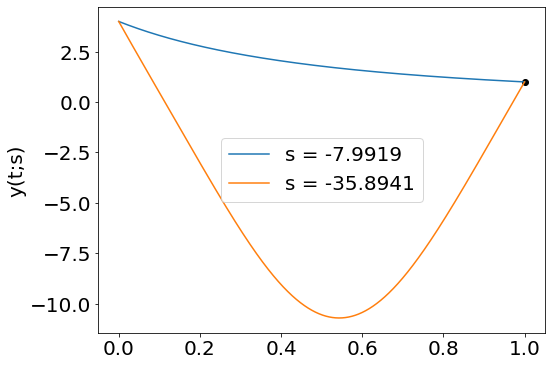

In [ ]:
from scipy.optimize import newton

def F(s):
    sol = solve_ivp(rhs, [0,1], [4,s], t_eval=[0,1])
    return sol.y[0,-1] - 1

trange = np.linspace(0,1,1000)

roots = [-7,-40] # A little different from [-8, -36], just to test for stability

for r in roots:
    s = newton(F, r)
    sol1 = solve_ivp(rhs, [0,1], [4,s], t_eval=trange)
    plt.plot(trange, sol1.y[0,:], label=f's = {s:1.4f}')


plt.scatter(1,1, color='black')
plt.legend()
plt.ylabel('y(t;s)')
plt.show()

### Problem: Stress-testing a pressure vessel

Consider a cylindrical pressure vessel that is being tested in the laboratory to check its ability to withstand pressure.  For a thick pressure vessel of inner radius $a$ and outer radius $b$, the differential equation for the radial displacement $u$ of a point along the circular cross-section is given by 
\begin{equation*}
\frac{d^2u}{dr^2}+\frac{1}{r}\frac{du}{dr}-\frac{u}{r^2}=0.
\end{equation*}

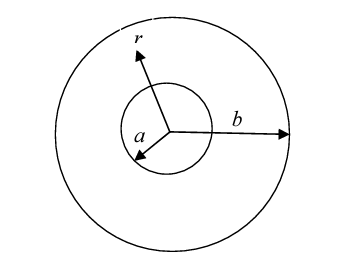

Let the inner radius $a=5cm$ and outer radius $b=8cm$. Two strain gages that are bonded tangentially at the inner and the outer radius measure the normal tangential strain in the pressure vessel as  
\begin{equation*}
\epsilon_a = 0.00077462
\end{equation*}
\begin{equation*}
\epsilon_b = 0.00038462
\end{equation*}

Our objective is to use these two boundary conditions to solve for the tangential strain across the vessel. Note that, since tangential strain $\epsilon\equiv u/r$, the boundary conditions are $u(a)=0.00077462\times 5 = 0.0038731\;cm$, and $u(b) = 0.00038462\times 8 = 0.00307696\;cm$.

We shall now use the *shooting method* to determine $u(r;s)$, where $r$ is the variable and the parameter $s$ determines the initial conditions $u(a;s) = u_a, v(a;s) = s$. Thus, we have to solve the initial value problem
\begin{equation*}
\begin{matrix}
\frac{du}{dt} &=v\\
\frac{dv}{dt} &= \frac{u}{r^2}-\frac{v}{r}
\end{matrix},
\end{equation*}
with $u(a;s)=0.0038731$, and $v(a)=s$ is the solution to $u(b;s) - 0.00307696 = 0$. Define a function $F(s) = u(b;s)-0.00307696$. The function $u(b; s)$ is obtained by numerically solving the IVP given above with initial conditions $u(a)=0.0077462, v(a)=s$ from $r=a$ to $r=b$.

In the code cell below, we choose the default integrator in the $solve\_ivp$ routine in scipy for the integration of $u(r)$, and the Newton-Raphson method from the $scipy.integrate.newton$ routine to obtain the zero of $F(s)$. 

**Exercise**: Inspect the code below and write an additional line to print the correct value of 's'.


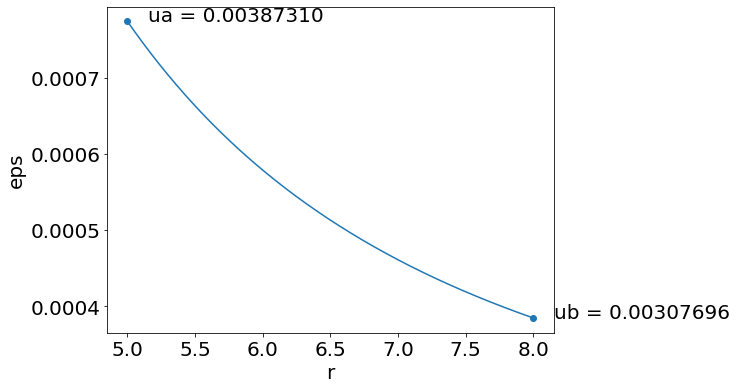

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import newton

a = 5
b = 8

ua = 0.0038731
ub = 0.00307696

def rhs(r,uvec):
    u,v = uvec
    dudr = v
    dvdr = u/r**2 - v/r
    return [dudr, dvdr]

def F(s):
    """
    Solves the radial strain equation for initial gradient va at radius r
    The initial value of r is hard coded to the global 'a'
    """
    sol = solve_ivp(rhs, [a, b], [ua, s], t_eval=[a,b])
    return sol.y[0,-1]-ub

va = newton(F, 0.1) # The '0.1' is a totally random guess 

rspace = np.linspace(a, b, 1000)

sol = solve_ivp(rhs, [a, b], [ua, va], t_eval=rspace)

plt.plot(rspace, sol.y[0]/rspace,'o', ls='-', markevery=[0,-1])

eps_a = sol.y[0,0]/a
eps_b = sol.y[0,-1]/b
offset = 0.15

plt.annotate(f'ua = {sol.y[0,0]:1.8f}',(a+offset, eps_a))
plt.annotate(f'ub = {sol.y[0,-1]:1.8f}',(b+offset, eps_b))
plt.xlabel('r')
plt.ylabel('eps')
plt.show()